In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM as tp_lc_functions

In [2]:
# Using the 0D TNG100 SIM data at z=0 (version 5 of the dataset in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v5_TNG-SIM_0D_Dataset.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 16)
df_raw.shape (21598, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

In [3]:
def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

In [4]:
df_raw_log = log_df(df_raw)

In [5]:
df_raw_log.head(2)

SubhaloBHMass_log  SubhaloBHMdot_log  SubhaloGasMetallicity_log  \
0           9.998109          -3.400095                  -2.112483   
1           9.898275          -4.012083                  -2.359742   

   SubhaloSFRinRad_log  SubhaloStarMetallicity_log  SubhaloVelDisp_log  \
0            -0.708133                   -1.543295            2.780947   
1             0.219496                   -1.679031            2.774496   

   SubhaloVmax_log  SubhaloVmaxRad_log  SubhaloRgas_log  SubhaloRstar_log  \
0         2.999733            2.668073         2.949910          1.828096   
1         2.981978            3.134860         2.988572          2.098578   

   SubhaloMgas_log  SubhaloMstar_log  GroupNsubs_log  Group_M_TopHat200_log  \
0        13.092064         12.497443        4.235150              14.646987   
1        13.610459         12.316876        4.150971              14.687475   

   Group_R_TopHat200_log  SubhaloMHI_log  SubhaloMH2_log  \
0               3.292134       10.061858       10.043734   
1               3.305635        9.899765        9.955786   

   Group_V_TopHat200_log  GroupSpin_dmo_log  
0               2.994161          -1.769689  
1               3.007654          -1.893303

In [6]:
df_raw_log.shape

(21598, 19)

In [7]:
df_raw.shape

(21598, 19)

In [8]:
df_0D_log = log_df(df_0D)

In [9]:
df_0D_log.shape

(21598, 16)

In [10]:
df_0D.shape

(21598, 16)

In [11]:
df_0D_log.head(2)

SubhaloGasMetallicity_log  SubhaloSFRinRad_log  SubhaloStarMetallicity_log  \
0                  -2.112483            -0.708133                   -1.543295   
1                  -2.359742             0.219496                   -1.679031   

   GroupNsubs_log  GroupSpin_dmo_log  SubhaloRstar_hs_log  SubhaloRgas_hs_log  \
0        4.235150          -1.769689            -1.464038           -0.342224   
1        4.150971          -1.893303            -1.207057           -0.317063   

   SubhaloVmaxRad_hs_log  SubhaloVmax_hs_log  SubhaloVelDisp_hs_log  \
0              -0.624060            0.005572              -0.213213   
1              -0.170775           -0.025676              -0.233158   

   SubhaloMgas_hs_log  SubhaloMstar_hs_log  SubhaloBHMass_hs_log  \
0           -1.554922            -2.149543             -4.648685   
1           -1.077015            -2.370598             -4.788932   

   SubhaloBHMdot_hs_log  SubhaloMHI_hs_log  SubhaloMH2_hs_log  
0                  -8.0          -4.584962          -4.603079  
1                  -8.0          -4.787443          -4.731455

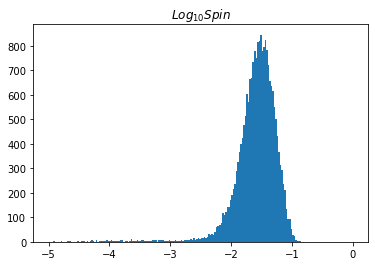

In [12]:
plt.hist(df_raw_log.GroupSpin_dmo_log, bins=200, range=(-5, 0))
plt.title(r'$Log_{10}Spin$')
plt.show()

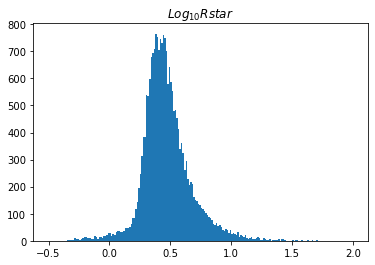

In [13]:
plt.hist(df_raw_log.SubhaloRstar_log, bins=200, range=(-0.5, 2.0))
plt.title(r'$Log_{10}Rstar$')
plt.show()

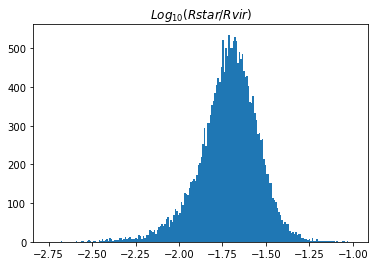

In [14]:
plt.hist(df_0D_log.SubhaloRstar_hs_log, bins=200, range=(-2.75, -1.0))
plt.title(r'$Log_{10}(Rstar/Rvir)$')
plt.show()

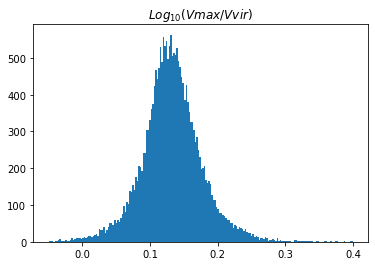

In [15]:
plt.hist(df_0D_log.SubhaloVmax_hs_log, bins=200, range=(-0.05, 0.4))
plt.title(r'$Log_{10}(Vmax/Vvir)$')
plt.show()

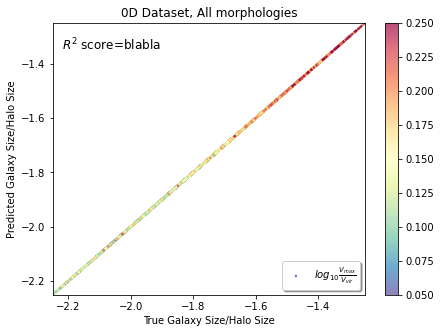

In [16]:
# Plot of 0D Rstar vs 0D Rstar to see the scale needed for the plot

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_0D_log.SubhaloRstar_hs_log, df_0D_log.SubhaloRstar_hs_log,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-2.22, -1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([-2.25,-1.25, -2.25,-1.25])
# ax.plot([-3.0, -1.0], [-3.0, -1.0], color = 'black', linewidth = 2)
ax.set_title(r'0D Dataset, All morphologies')
ax.set_xlabel('True Galaxy Size/Halo Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/Rstar_vs_Rstar.jpeg', dpi=500)
plt.show()

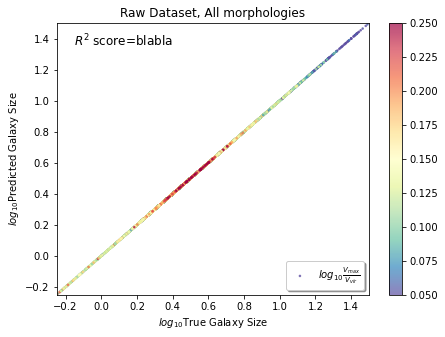

In [35]:
# Plot of Raw Rstar vs Raw Rstar to see the scale needed for the plot

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, df_raw_log.SubhaloRstar_log,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title(r'Raw Dataset, All morphologies')
ax.set_xlabel(r'$log_{10}$True Galaxy Size')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel(r'$log_{10}$Predicted Galaxy Size')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/Rstar_vs_Rstar.jpeg', dpi=500)
plt.show()

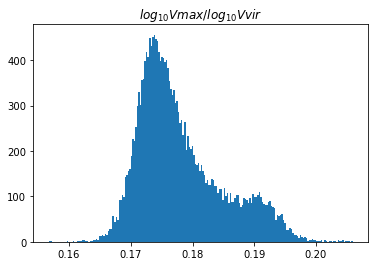

In [32]:
plt.hist(df_raw_log.SubhaloVmax_log/df_raw_log.Group_M_TopHat200_log, bins=200)
plt.title(r'$log_{10}Vmax/log_{10}Vvir$')
plt.show()

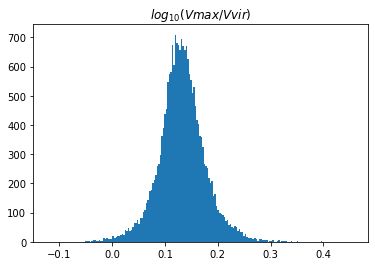

In [31]:
plt.hist(df_0D_log.SubhaloVmax_hs_log, bins=200)
plt.title(r'$log_{10}(Vmax/Vvir)$')
plt.show()

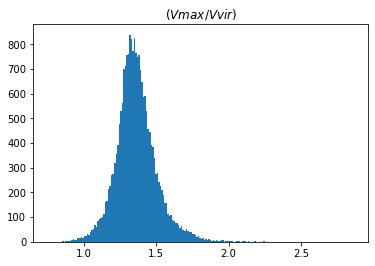

In [69]:
plt.hist(df_0D.SubhaloVmax_hs, bins=200)
plt.title(r'$(Vmax/Vvir)$')
plt.show()

### <font color='purple'> <a id =10> </a> <br> Complete Raw Dataset: RF & Feature Ranking

In [18]:
df_raw_log.columns.to_list()

['SubhaloBHMass_log',
 'SubhaloBHMdot_log',
 'SubhaloGasMetallicity_log',
 'SubhaloSFRinRad_log',
 'SubhaloStarMetallicity_log',
 'SubhaloVelDisp_log',
 'SubhaloVmax_log',
 'SubhaloVmaxRad_log',
 'SubhaloRgas_log',
 'SubhaloRstar_log',
 'SubhaloMgas_log',
 'SubhaloMstar_log',
 'GroupNsubs_log',
 'Group_M_TopHat200_log',
 'Group_R_TopHat200_log',
 'SubhaloMHI_log',
 'SubhaloMH2_log',
 'Group_V_TopHat200_log',
 'GroupSpin_dmo_log']

In [19]:
X_all = df_raw_log.drop(columns=['SubhaloRstar_log'])
 

y_all = df_raw_log.loc[:,'SubhaloRstar_log']

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.8711 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}
RF Accuracy: 0.87 (+/- 0.01)


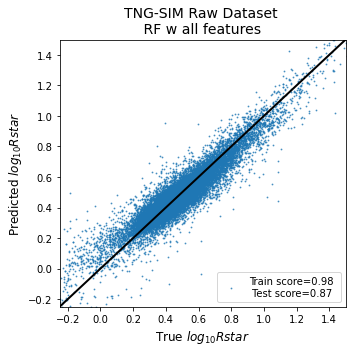

Elapsed time to compute the importances: 0.369 seconds
Elapsed time to compute the importances: 183.938 seconds


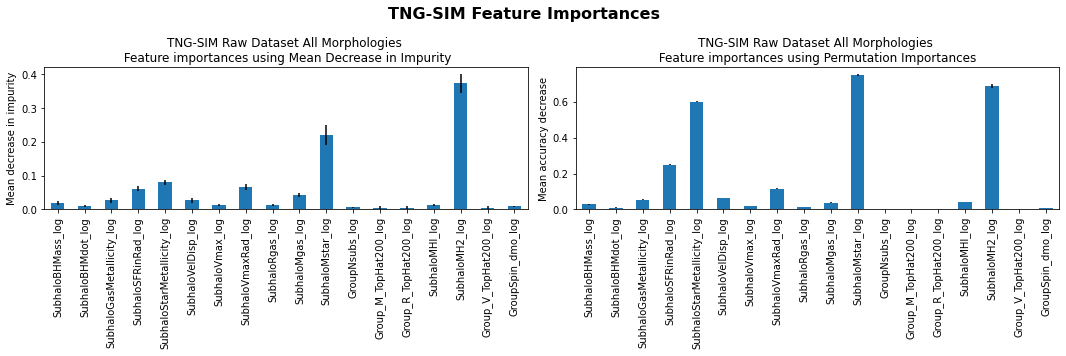

  0%|                                                    | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, m

  6%|██▍                                        | 1/18 [01:53<32:16, 113.92s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

 11%|████▊                                      | 2/18 [03:55<31:30, 118.18s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_feature

 17%|███████▏                                   | 3/18 [05:53<29:32, 118.19s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=No

 22%|█████████▌                                 | 4/18 [07:52<27:42, 118.74s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=No

 28%|███████████▉                               | 5/18 [10:01<26:30, 122.33s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_fe

 33%|██████████████▎                            | 6/18 [12:00<24:13, 121.16s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_fea

 39%|████████████████▋                          | 7/18 [14:02<22:16, 121.50s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=No

 44%|███████████████████                        | 8/18 [16:21<21:10, 127.00s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  14.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  14.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.2s
[CV] END bootstrap=True, max_depth=

 50%|█████████████████████▌                     | 9/18 [18:43<19:45, 131.77s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto

 56%|███████████████████████▎                  | 10/18 [20:47<17:14, 129.28s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  14.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=2, 

 61%|█████████████████████████▋                | 11/18 [22:58<15:09, 129.96s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 67%|████████████████████████████              | 12/18 [23:37<10:13, 102.27s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=

 72%|██████████████████████████████▎           | 13/18 [25:40<09:02, 108.55s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  13.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.9s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.0s


 78%|████████████████████████████████▋         | 14/18 [27:42<07:30, 112.58s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=N

 83%|███████████████████████████████████       | 15/18 [29:46<05:47, 115.89s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   2.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=N

 89%|█████████████████████████████████████▎    | 16/18 [31:46<03:54, 117.32s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_feature

 94%|███████████████████████████████████████▋  | 17/18 [34:04<02:03, 123.50s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.7s
[CV] END bootstrap=True, max_depth=No

100%|██████████████████████████████████████████| 18/18 [36:22<00:00, 121.27s/it]


1. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715


  0%|                                                    | 0/17 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  13.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  19.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=2, 

  6%|██▌                                        | 1/17 [02:45<44:02, 165.16s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.6s


 12%|█████                                      | 2/17 [05:34<41:54, 167.64s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  18.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=

 18%|███████▌                                   | 3/17 [08:37<40:44, 174.63s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  20.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=N

 24%|██████████                                 | 4/17 [11:33<37:55, 175.03s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.9s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, 

 29%|████████████▋                              | 5/17 [14:42<36:02, 180.22s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  19.4s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  14.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_

 35%|███████████████▏                           | 6/17 [18:00<34:10, 186.38s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.9s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.3s
[CV] END bootstrap=True, max_depth=N

 41%|█████████████████▋                         | 7/17 [21:10<31:13, 187.38s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  21.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  22.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=No

 47%|████████████████████▏                      | 8/17 [24:24<28:26, 189.58s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  22.8s
[CV] END bootstrap=True, max_depth=None, max

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.3s


 53%|██████████████████████▊                    | 9/17 [27:30<25:06, 188.34s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  21.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  20.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  13.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=No

 59%|████████████████████████▋                 | 10/17 [30:29<21:38, 185.55s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total tim

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  20.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  21.9s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, mi

 65%|███████████████████████████▏              | 11/17 [33:28<18:20, 183.49s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=No

 71%|█████████████████████████████▋            | 12/17 [35:46<14:08, 169.64s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  20.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=N

 76%|████████████████████████████████          | 13/17 [38:40<11:24, 171.12s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  20.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=No

 82%|██████████████████████████████████▌       | 14/17 [41:35<08:36, 172.07s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_

 88%|█████████████████████████████████████     | 15/17 [44:32<05:47, 173.72s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  22.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  19.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.2s
[CV] END bootstrap=True, max_depth=No

 94%|███████████████████████████████████████▌  | 16/17 [47:26<02:53, 173.90s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  21.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  19.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features

100%|██████████████████████████████████████████| 17/17 [50:09<00:00, 177.01s/it]


2. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835


  0%|                                                    | 0/16 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  27.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=N

  6%|██▋                                        | 1/16 [03:23<50:59, 203.99s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  26.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_feature

 12%|█████▍                                     | 2/16 [06:45<47:11, 202.27s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=

 19%|████████                                   | 3/16 [10:03<43:29, 200.70s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  27.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  24.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_featur

 25%|██████████▊                                | 4/16 [13:20<39:49, 199.15s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  23.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.0s


 31%|█████████████▍                             | 5/16 [16:37<36:20, 198.20s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  28.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=Non

 38%|████████████████▏                          | 6/16 [20:03<33:30, 201.06s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  25.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  24.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  29.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  26.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=N

 44%|██████████████████▊                        | 7/16 [23:29<30:22, 202.51s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  28.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  26.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=Non

 50%|█████████████████████▌                     | 8/16 [26:52<27:02, 202.75s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  27.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  25.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  25.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.4s


 56%|████████████████████████▏                  | 9/16 [30:17<23:45, 203.59s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_featur

 62%|██████████████████████████▎               | 10/16 [33:37<20:13, 202.25s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  27.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  24.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=N

 69%|████████████████████████████▉             | 11/16 [36:31<16:08, 193.73s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  28.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=No

 75%|███████████████████████████████▌          | 12/16 [39:56<13:08, 197.21s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  25.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, ma

 81%|██████████████████████████████████▏       | 13/16 [43:21<09:58, 199.59s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  28.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  27.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=No

 88%|████████████████████████████████████▊     | 14/16 [46:46<06:42, 201.18s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  28.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  25.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features

 94%|███████████████████████████████████████▍  | 15/16 [50:11<03:22, 202.11s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  28.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  25.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.7s


100%|██████████████████████████████████████████| 16/16 [53:37<00:00, 201.08s/it]


3. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835
	 3 SubhaloMstar_log 0.6842870856226811


  0%|                                                    | 0/15 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  28.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.8s
[CV] END bootstrap=True, max_depth=No

  7%|██▋                                      | 1/15 [04:31<1:03:14, 271.00s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  31.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.5s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.8s
[CV] END bootstrap=True, max_depth=No

 13%|█████▋                                     | 2/15 [09:02<58:48, 271.39s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  30.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.1s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  32.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=No

 20%|████████▌                                  | 3/15 [13:29<53:51, 269.29s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  31.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.8s
[CV] END bootstrap=True, max_depth=No

 27%|███████████▍                               | 4/15 [17:55<49:07, 267.95s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  30.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=No

 33%|██████████████▎                            | 5/15 [22:30<45:06, 270.61s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  21.1s
[CV] END bootstrap=True, max_depth=No

 40%|█████████████████▏                         | 6/15 [26:59<40:29, 269.99s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  30.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  31.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  21.1s


 47%|████████████████████                       | 7/15 [31:32<36:07, 270.91s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.9s
[CV] END bootstrap=True, max_depth=No

 53%|██████████████████████▉                    | 8/15 [36:01<31:31, 270.23s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  34.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  31.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  21.1s
[CV] END bootstrap=True, max_depth=No

 60%|█████████████████████████▊                 | 9/15 [40:32<27:04, 270.72s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  19.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.0s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  29.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=No

 67%|████████████████████████████              | 10/15 [44:32<21:46, 261.21s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  19.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.1s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  21.2s
[CV] END bootstrap=True, max_depth=No

 73%|██████████████████████████████▊           | 11/15 [49:03<17:36, 264.22s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  29.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   5.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   5.9s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  31.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=No

 80%|█████████████████████████████████▌        | 12/15 [53:34<13:18, 266.32s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  30.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  34.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  31.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  19.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=au

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  21.1s
[CV] END bootstrap=True, max_depth=No

 87%|████████████████████████████████████▍     | 13/15 [58:08<08:57, 268.60s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.8s
[CV] END bootstrap=True, max_depth=No

 93%|█████████████████████████████████████▎  | 14/15 [1:02:40<04:29, 269.56s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=a

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  34.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  33.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.7s
[CV] END bootstrap=True, max_depth=No

100%|████████████████████████████████████████| 15/15 [1:07:13<00:00, 268.90s/it]


4. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835
	 3 SubhaloMstar_log 0.6842870856226811
	 4 SubhaloStarMetallicity_log 0.8315600726279152


  0%|                                                    | 0/14 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  31.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.6s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  35.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.7s


  7%|██▉                                      | 1/14 [04:53<1:03:30, 293.09s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  38.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  35.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   3.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=5, max_features=auto,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  34.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.8s


 14%|█████▊                                   | 2/14 [10:01<1:00:26, 302.20s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  38.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  35.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  36.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.9s
[CV] END bootstrap=True, max_depth=No

 21%|█████████▏                                 | 3/14 [15:04<55:28, 302.57s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  37.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  34.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  36.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.9s
[CV] END bootstrap=True, max_depth=No

 29%|████████████▎                              | 4/14 [20:06<50:21, 302.20s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  18.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   6.9s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  35.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.5s


 36%|███████████████▎                           | 5/14 [25:12<45:31, 303.52s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  38.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  35.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  37.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.5s
[CV] END bootstrap=True, max_depth=No

 43%|██████████████████▍                        | 6/14 [29:59<39:44, 298.11s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  37.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  35.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  37.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.7s
[CV] END bootstrap=True, max_depth=No

 50%|█████████████████████▌                     | 7/14 [35:08<35:11, 301.60s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  37.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  35.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   6.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  35.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  34.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.2s


 57%|████████████████████████▌                  | 8/14 [40:14<30:17, 302.87s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  38.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  35.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  37.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=5, max_features=auto

 64%|███████████████████████████▋               | 9/14 [44:52<24:36, 295.31s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  38.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.7s
[CV] END bootstrap=True, max_depth=No

 71%|██████████████████████████████            | 10/14 [50:00<19:55, 298.97s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  35.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

 79%|█████████████████████████████████         | 11/14 [55:06<15:03, 301.29s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  38.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.5s
[CV] END bootstrap=True, max_depth=No

 86%|██████████████████████████████████▎     | 12/14 [1:00:14<10:06, 303.23s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  37.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=No

 93%|█████████████████████████████████████▏  | 13/14 [1:05:18<05:03, 303.40s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  38.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.8s
[CV] END bootstrap=True, max_depth=No

100%|████████████████████████████████████████| 14/14 [1:10:24<00:00, 301.71s/it]


5. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835
	 3 SubhaloMstar_log 0.6842870856226811
	 4 SubhaloStarMetallicity_log 0.8315600726279152
	 5 SubhaloBHMass_log 0.8457439329785071


  0%|                                                    | 0/13 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  35.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  44.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.5s
[CV] END bootstrap=True, max_depth=N

  8%|███▏                                     | 1/13 [05:37<1:07:35, 337.95s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  38.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  36.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   8.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  43.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=N

 15%|██████▎                                  | 2/13 [11:12<1:01:34, 335.84s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  40.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  43.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=

 23%|█████████▉                                 | 3/13 [16:46<55:51, 335.12s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  44.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=No

 31%|█████████████▏                             | 4/13 [22:23<50:22, 335.87s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  40.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  41.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, ma

 38%|████████████████▌                          | 5/13 [27:37<43:44, 328.04s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.6s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  43.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  41.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  44.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=No

 46%|███████████████████▊                       | 6/13 [33:20<38:50, 332.93s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  41.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  44.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=N

 54%|███████████████████████▏                   | 7/13 [38:59<33:31, 335.18s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  41.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  41.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=N

 62%|██████████████████████████▍                | 8/13 [44:14<27:22, 328.46s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  37.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=Non

 69%|█████████████████████████████▊             | 9/13 [49:52<22:06, 331.65s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  41.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max

 77%|████████████████████████████████▎         | 10/13 [55:28<16:38, 332.89s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  44.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  41.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  41.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_fea

 85%|█████████████████████████████████▊      | 11/13 [1:01:06<11:08, 334.39s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  44.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=N

 92%|████████████████████████████████████▉   | 12/13 [1:06:42<05:34, 334.85s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  41.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  44.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=No

100%|████████████████████████████████████████| 13/13 [1:12:18<00:00, 333.72s/it]


6. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835
	 3 SubhaloMstar_log 0.6842870856226811
	 4 SubhaloStarMetallicity_log 0.8315600726279152
	 5 SubhaloBHMass_log 0.8457439329785071
	 6 SubhaloSFRinRad_log 0.8547231496211815


  0%|                                                    | 0/12 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, max_depth=N

  8%|███▍                                     | 1/12 [06:08<1:07:35, 368.68s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=N

 17%|██████▊                                  | 2/12 [12:18<1:01:35, 369.59s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  50.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  47.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  44.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  41.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.9s
[CV] END bootstrap=True, max_depth=2, max_

 25%|██████████▊                                | 3/12 [18:28<55:28, 369.81s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   9.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  46.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

 33%|██████████████▎                            | 4/12 [24:39<49:20, 370.09s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=N

 42%|█████████████████▉                         | 5/12 [30:52<43:16, 370.97s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  49.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  46.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=No

 50%|█████████████████████▌                     | 6/12 [37:06<37:12, 372.04s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  47.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  46.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=No

 58%|█████████████████████████                  | 7/12 [42:53<30:20, 364.03s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  46.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  43.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, ma

 67%|████████████████████████████▋              | 8/12 [49:04<24:24, 366.12s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  50.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  47.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=N

 75%|████████████████████████████████▎          | 9/12 [55:12<18:20, 366.79s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.0s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_fea

 83%|█████████████████████████████████▎      | 10/12 [1:01:22<12:15, 367.79s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  49.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  47.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  13.1s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   8.8s
[CV] END bootstrap=True, max_depth=2, max

 92%|████████████████████████████████████▋   | 11/12 [1:07:29<06:07, 367.41s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  50.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  20.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  49.2s
[CV] END bootstrap=True, max_depth=

100%|████████████████████████████████████████| 12/12 [1:13:40<00:00, 368.34s/it]


7. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835
	 3 SubhaloMstar_log 0.6842870856226811
	 4 SubhaloStarMetallicity_log 0.8315600726279152
	 5 SubhaloBHMass_log 0.8457439329785071
	 6 SubhaloSFRinRad_log 0.8547231496211815
	 7 SubhaloGasMetallicity_log 0.8646847595768298


  0%|                                                    | 0/11 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   9.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  47.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  48.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  46.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  57.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=N

  9%|███▋                                     | 1/11 [06:49<1:08:11, 409.12s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  48.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  46.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  18.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_fe

 18%|███████▍                                 | 2/11 [13:34<1:01:03, 407.03s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=2

 27%|███████████▋                               | 3/11 [20:23<54:23, 407.89s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  56.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.5s
[CV] END bootstrap=True, max_depth=No

 36%|███████████████▋                           | 4/11 [27:20<47:59, 411.31s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, max_fe

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=Non

 45%|███████████████████▌                       | 5/11 [34:08<41:01, 410.27s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  56.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  53.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  54.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   9.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=N

 55%|███████████████████████▍                   | 6/11 [40:35<33:30, 402.17s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  10.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  54.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  55.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=No

 64%|███████████████████████████▎               | 7/11 [47:19<26:51, 402.83s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  52.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  49.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  55.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  19.0s
[CV] END bootstrap=True, max_depth=No

 73%|███████████████████████████████▎           | 8/11 [53:58<20:05, 401.78s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  54.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=Non

 82%|█████████████████████████████████▌       | 9/11 [1:00:43<13:25, 402.74s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50;

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, ma

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  56.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  52.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.6s
[CV] END bootstrap=True, max_depth=

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  56.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=No

 91%|████████████████████████████████████▎   | 10/11 [1:07:23<06:41, 401.89s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  15.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  56.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  53.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  55.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=Non

100%|████████████████████████████████████████| 11/11 [1:14:05<00:00, 404.17s/it]


8. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835
	 3 SubhaloMstar_log 0.6842870856226811
	 4 SubhaloStarMetallicity_log 0.8315600726279152
	 5 SubhaloBHMass_log 0.8457439329785071
	 6 SubhaloSFRinRad_log 0.8547231496211815
	 7 SubhaloGasMetallicity_log 0.8646847595768298
	 8 SubhaloVelDisp_log 0.8676994458523533


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  56.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  53.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  56.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  53.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_featur

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=No

 10%|████                                     | 1/10 [07:51<1:10:46, 471.85s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  59.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_f

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  14.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=No

 20%|████████▏                                | 2/10 [15:43<1:02:54, 471.76s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  25.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  15.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=No

 30%|████████████▉                              | 3/10 [24:22<57:31, 493.09s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.9s
[CV] END bootstrap=True, max_depth=2,

 40%|█████████████████▏                         | 4/10 [32:07<48:12, 482.10s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  58.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.6s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  22.6s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  58.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=No

 50%|█████████████████████▌                     | 5/10 [39:27<38:55, 467.14s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  22.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  57.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=Non

 60%|█████████████████████████▊                 | 6/10 [47:09<31:01, 465.25s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_fe

 70%|██████████████████████████████             | 7/10 [54:55<23:16, 465.58s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  59.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  11.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  55.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  25.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  59.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.4s
[CV] END bootstrap=True, max_depth=N

 80%|████████████████████████████████▊        | 8/10 [1:02:42<15:31, 465.85s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  57.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_feat

 90%|████████████████████████████████████▉    | 9/10 [1:10:25<07:45, 465.15s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  58.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  22.8s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  58.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=N

100%|████████████████████████████████████████| 10/10 [1:18:08<00:00, 468.82s/it]


9. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835
	 3 SubhaloMstar_log 0.6842870856226811
	 4 SubhaloStarMetallicity_log 0.8315600726279152
	 5 SubhaloBHMass_log 0.8457439329785071
	 6 SubhaloSFRinRad_log 0.8547231496211815
	 7 SubhaloGasMetallicity_log 0.8646847595768298
	 8 SubhaloVelDisp_log 0.8676994458523533
	 9 SubhaloMHI_log 0.8697075199413792


  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_fea

 11%|████▋                                     | 1/9 [08:28<1:07:46, 508.35s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  57.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.5s
[CV] END bootstrap=True, max_depth=2

 22%|█████████▊                                  | 2/9 [17:02<59:44, 512.00s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  25.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; tota

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=No

 33%|██████████████▋                             | 3/9 [25:37<51:17, 512.98s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  21.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; to

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=Non

 44%|███████████████████▌                        | 4/9 [34:17<42:59, 515.95s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  25.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  25.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_featu

 56%|████████████████████████▍                   | 5/9 [42:29<33:49, 507.27s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  25.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  21.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  25.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  12.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  12.1s
[CV] END bootstrap=True, max_depth=2, max_featu

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  20.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, m

 67%|█████████████████████████████▎              | 6/9 [51:06<25:31, 510.62s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  24.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  23.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  27.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.1s
[CV] END bootstrap=True, max_depth=N

 78%|██████████████████████████████████▏         | 7/9 [59:40<17:03, 511.86s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimator

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  23.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.1s
[CV] END bootstrap=True, max_depth=2,

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  21.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, m

 89%|█████████████████████████████████████▎    | 8/9 [1:08:15<08:32, 512.77s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  21.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  13.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.4s
[CV] END bootstrap=True, max_depth=2

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.5s
[CV] END bootstrap=True, max_depth=No

100%|██████████████████████████████████████████| 9/9 [1:16:51<00:00, 512.35s/it]

10. iteration: 
	 1 SubhaloMH2_log 0.47937819392234715
	 2 SubhaloVmaxRad_log 0.5969370370660835
	 3 SubhaloMstar_log 0.6842870856226811
	 4 SubhaloStarMetallicity_log 0.8315600726279152
	 5 SubhaloBHMass_log 0.8457439329785071
	 6 SubhaloSFRinRad_log 0.8547231496211815
	 7 SubhaloGasMetallicity_log 0.8646847595768298
	 8 SubhaloVelDisp_log 0.8676994458523533
	 9 SubhaloMHI_log 0.8697075199413792
	 10 Group_V_TopHat200_log 0.8707515308924162


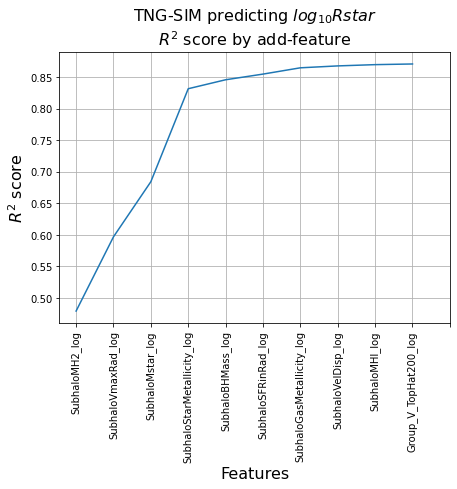

Elapsed time to run RF func on Raw TNG-SIM: 49846.619 seconds
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   6.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 1.2min
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  24.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=No

In [20]:
# this code takes 50293.695 seconds ~ 14 hrs to run when the dataset is TNG-SIM galaxies with ~22,000 entries
# and 19 features (480 models for the RF (total 2400 fits);
# 288 models for each add-on feature ranking step, cv=3, so 864 fits )
start_time = time.time()

RF_results_all = functions.target_predicting_RF_function(X=X_all, y=y_all)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Raw TNG-SIM: {elapsed_time:.3f} seconds")

Fitting 5 folds for each of 480 candidates, totalling 2400 fits

Best params, best score: 0.8711 {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700}

RF Accuracy: 0.87 (+/- 0.01)

<!--     n_estimators = [20, 50,100, 500, 700]
    # create random grid
    grid = {'bootstrap': [True],
                   'max_depth': [2, 5, 10, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4, 8],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    # Grid search of parameters
    rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True),                          verbose = 1, n_jobs = -1, return_train_score=True)

For feature ranking:

Fitting 3 folds for each of 288 candidates, totalling 864 fits

    n_estimators = [50,100, 500]
    grid = {'bootstrap': [True],
                   'max_depth': [2, 5, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5],
                   'n_estimators': n_estimators} -->

#### The most important features, Raw Dataset (TNG100-SIM, log10features predicting log10Rstar) are:


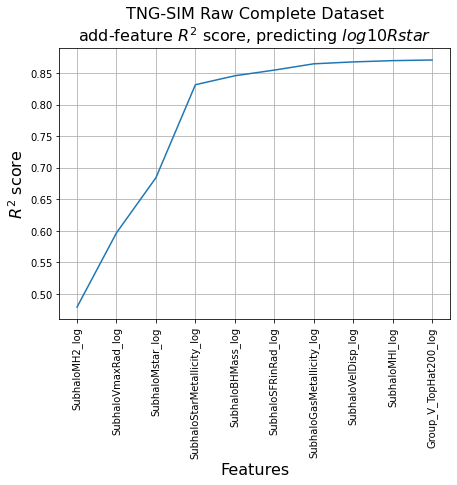

In [22]:
all_0D_fig_add_feature=RF_results_all[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,10))
all_0D_fig_add_feature.set_title(label= r'TNG-SIM Raw Complete Dataset' + '\n' + r'add-feature $R^{2}$ score, predicting $log{10}Rstar$',fontsize=16)
all_0D_fig_add_feature.set_xlabel('Features',fontsize=16)
all_0D_fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

# all_0D_fig_add_feature.get_figure().savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_R_score_by_add_feature.jpg', dpi=500)

plt.show()

In [23]:
# RF_results_all[4].to_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG_Raw_AllDataset_Max_r_scores_by_add_column_method.csv', index=False)

all_raw = pd.read_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG_Raw_AllDataset_Max_r_scores_by_add_column_method.csv')

all_raw_fig = RF_results_all[1]
# all_raw_fig.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG_Raw_AllDataset_RF_Prediction_vs_True.jpeg', dpi=500)
plt.show()

all_raw_fig_builtin_imp = RF_results_all[2]
# all_raw_fig_builtin_imp.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v16_TNG_Raw_AllDataset_Built_in_Feature_Ranking.jpeg', dpi=500)
plt.show()

In [11]:
# y_pred_RF_df_all = RF_results_all[0]
# y_pred_RF_df_all = pd.DataFrame({'y_pred_RF SIM Raw': y_pred_RF_df_all})

# y_pred_RF_df_all.to_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_y_pred_RF_predicted_sizes.csv', index=False)

y_pred_RF_all = pd.read_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_y_pred_RF_predicted_sizes.csv')

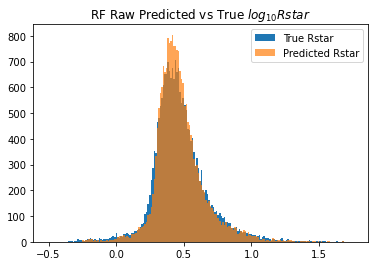

In [14]:
plt.hist(df_raw_log.SubhaloRstar_log, bins=200, label='True Rstar'
        , range=(-0.50, 1.75))
plt.hist(y_pred_RF_all.loc[:, 'y_pred_RF SIM Raw'], bins=200, alpha=0.7, label='Predicted Rstar'
        , range=(-0.50, 1.75))
plt.legend(loc='upper right')
plt.title(r'RF Raw Predicted vs True $log_{10}Rstar$')
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_Histogram_RF_pred_true_TNG-SIM_Raw_AllDatasetwMvir.jpeg', dpi=500)
plt.show()

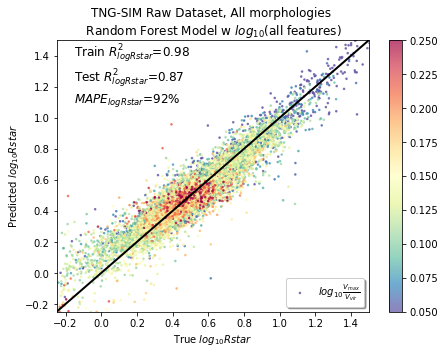

In [28]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, y_pred_RF_all,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.98' + '\n' + r'Test $R^{2}_{logRstar}$=0.87' + '\n' + r'$MAPE_{logRstar}$=92$\%$ ', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'Random Forest Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True $log_{10}Rstar$')
ax.set_ylabel(r'Predicted $log_{10}Rstar$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_RF_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

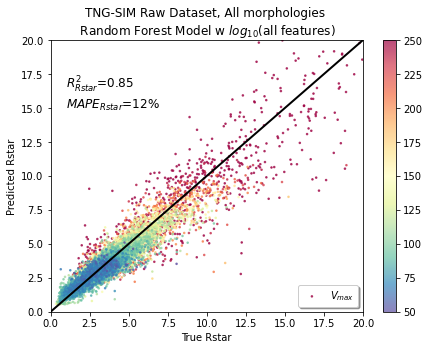

In [27]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_all),
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 15, r'$R^{2}_{Rstar}$=0.85' + '\n' + r'$MAPE_{Rstar}$=12$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([0, 30], [0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'Random Forest Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_RF_size_pred_colorlogVmaxVvir_2.jpeg', dpi=500)
plt.show()

### Other metrics

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('MSE logRstar:', mean_squared_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
print('sqrtMSE logRstar:', np.sqrt(mean_squared_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))
print('MAE logRstar:', mean_absolute_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
print('MAPE logRstar:', mean_absolute_percentage_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
print('r2 score logRstar:', r2_score(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))

print('Original var MAPE Rstar:', # MAPE in original variables
mean_absolute_percentage_error(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))
print('Origina var r2 score:', r2_score(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))

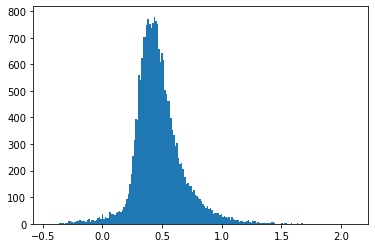

In [61]:
plt.hist(df_raw_log.loc[:, 'SubhaloRstar_log'], bins=200)
plt.show()

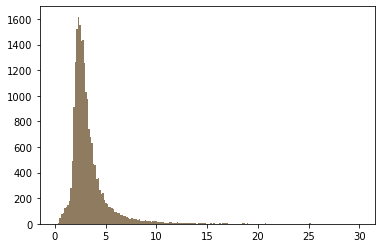

In [64]:
plt.hist(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), bins=200, range=(0,30))
plt.hist(df_raw.loc[:, 'SubhaloRstar'], bins=200, range=(0,30), alpha=0.5)
plt.show()

In [51]:
r2_score(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])

0.8715903025819992

### Learning Curve

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.8710 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
RF Accuracy: 0.87 (+/- 0.01)


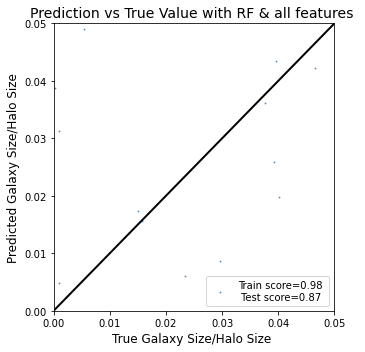

Elapsed time to compute the importances: 0.387 seconds
Elapsed time to compute the importances: 126.426 seconds


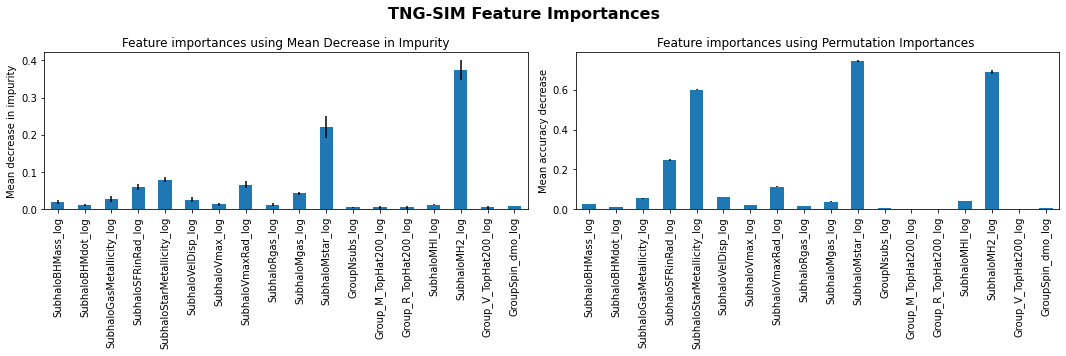

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


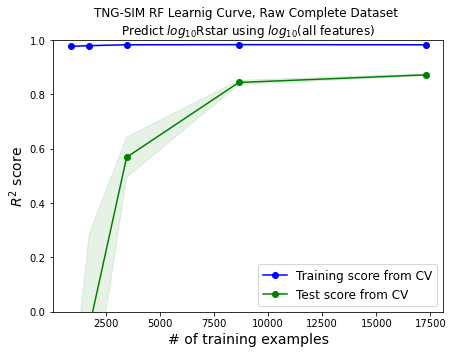

Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset: 1976.418 seconds


In [58]:
# this code takes 2242.162 seconds ~37min to run when the dataset is TNG100-SIM galaxies
# with ~22,000 entries 
start_time = time.time()

RF_lc_2 = tp_lc_functions.target_predicting_RF_function(X_all, y_all, 'TNG-SIM RF Learnig Curve, Raw Complete Dataset \n'+r'Predict $log_{10}$Rstar using $log_{10}$(all features)')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset: {elapsed_time:.3f} seconds")

In [59]:
lc_2 = RF_lc_2[4]
# lc_2.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_RF_Learning_Curve_zoom.jpeg', dpi=500)
lc_3 = RF_lc_2[2]
# lc_3.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_PermutationImportances.jpeg', dpi=500)
# RF_lc_2[3].to_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG_Raw_AllDataset_PermutationImportances.csv', index=False)


### <font color='purple'> <a id =10> </a> <br> Complete Raw Dataset w Dark-matter only features: RF & Feature Ranking

In [12]:
df_raw_log.columns.to_list()

['SubhaloBHMass_log',
 'SubhaloBHMdot_log',
 'SubhaloGasMetallicity_log',
 'SubhaloSFRinRad_log',
 'SubhaloStarMetallicity_log',
 'SubhaloVelDisp_log',
 'SubhaloVmax_log',
 'SubhaloVmaxRad_log',
 'SubhaloRgas_log',
 'SubhaloRstar_log',
 'SubhaloMgas_log',
 'SubhaloMstar_log',
 'GroupNsubs_log',
 'Group_M_TopHat200_log',
 'Group_R_TopHat200_log',
 'SubhaloMHI_log',
 'SubhaloMH2_log',
 'Group_V_TopHat200_log',
 'GroupSpin_dmo_log']

In [13]:
X_dm = df_raw_log.drop(columns=['SubhaloRstar_log', 
                                'SubhaloBHMass_log',
                                 'SubhaloBHMdot_log',
                                 'SubhaloGasMetallicity_log',
                                 'SubhaloSFRinRad_log',
                                 'SubhaloStarMetallicity_log',
                                 'SubhaloVelDisp_log',
                                 'SubhaloVmax_log',
                                 'SubhaloVmaxRad_log',
                                 'SubhaloRgas_log',
                                 'SubhaloRstar_log',
                                 'SubhaloMgas_log',
                                 'SubhaloMstar_log',
                             'SubhaloMHI_log',
                             'SubhaloMH2_log',]) # drop target and all galaxy properties
 

y_dm = df_raw_log.loc[:,'SubhaloRstar_log'] # predict target Rstar

In [14]:
X_dm.columns.to_list()

['GroupNsubs_log',
 'Group_M_TopHat200_log',
 'Group_R_TopHat200_log',
 'Group_V_TopHat200_log',
 'GroupSpin_dmo_log']

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.4259 {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 700}
RF Accuracy: 0.43 (+/- 0.02)


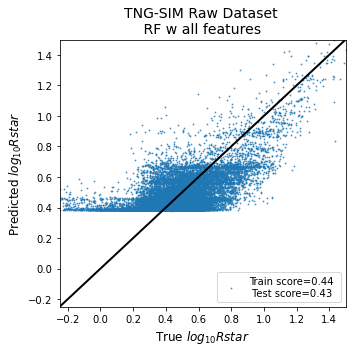

Elapsed time to compute the importances: 0.038 seconds
Elapsed time to compute the importances: 4.974 seconds


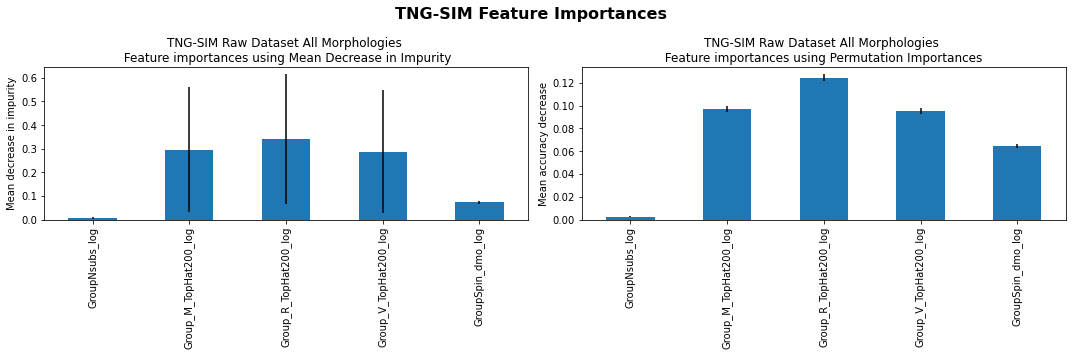

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits


 20%|█████████                                    | 1/5 [00:35<02:21, 35.26s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, m

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

 40%|██████████████████                           | 2/5 [02:34<04:13, 84.60s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=No

 60%|███████████████████████████                  | 3/5 [04:30<03:18, 99.09s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; t

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=Non

 80%|███████████████████████████████████▏        | 4/5 [06:19<01:43, 103.04s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  10.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.7s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  13.1s


100%|█████████████████████████████████████████████| 5/5 [08:17<00:00, 99.48s/it]


1. iteration: 
	 1 Group_R_TopHat200_log 0.39545963271457074


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimat

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   8.6s


 25%|███████████                                 | 1/4 [01:48<05:24, 108.32s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   6.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total 

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.6s
[CV] END bootstrap=True, max_depth=2, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   7.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_feat

 50%|██████████████████████                      | 2/4 [04:17<04:24, 132.08s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators

[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, mi

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, 

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.3s
[CV] END bootstrap=True, max_depth=2, max_f

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True,

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   3.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.1s
[CV] END bootstrap=True, max_depth=2, max_features

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.5s
[CV] END bootstrap=True, max_depth=No

 75%|█████████████████████████████████           | 3/4 [06:47<02:20, 140.36s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, m

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=au

100%|████████████████████████████████████████████| 4/4 [09:17<00:00, 139.28s/it]


2. iteration: 
	 1 Group_R_TopHat200_log 0.39545963271457074
	 2 GroupSpin_dmo_log 0.42379045236954904


  0%|                                                     | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; tot

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  19.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   8.2s


 33%|██████████████▋                             | 1/3 [02:33<05:07, 153.53s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   5.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   6.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   8.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.1s
[CV] END bootstrap=True, max_depth=2, m

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   3.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.5s
[CV] END bootstrap=True, max_depth=2, max

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  19.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  26.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.2s


 67%|█████████████████████████████▎              | 2/3 [05:41<02:53, 173.58s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  10.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   4.4s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  12.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=N

100%|████████████████████████████████████████████| 3/3 [08:51<00:00, 177.26s/it]


3. iteration: 
	 1 Group_R_TopHat200_log 0.39545963271457074
	 2 GroupSpin_dmo_log 0.42379045236954904
	 3 Group_M_TopHat200_log 0.4255904654032145


  0%|                                                     | 0/2 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  26.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  25.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=No

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   9.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.7s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=2, max_fea

[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   7.0s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.3s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   4.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_depth=None, max_features=

 50%|██████████████████████                      | 1/2 [03:42<03:42, 222.64s/it]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  18.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimat

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   4.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   2.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  11.8s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  28.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   5.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=N

100%|████████████████████████████████████████████| 2/2 [08:06<00:00, 243.48s/it]


4. iteration: 
	 1 Group_R_TopHat200_log 0.39545963271457074
	 2 GroupSpin_dmo_log 0.42379045236954904
	 3 Group_M_TopHat200_log 0.4255904654032145
	 4 Group_V_TopHat200_log 0.4251184203552391


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  39.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  32.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimato

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   5.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   5.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  20.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   6.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   6.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=   6.3s
[CV] END bootstrap=True, max_depth=2, max_feature

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  34.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=No

100%|████████████████████████████████████████████| 1/1 [04:20<00:00, 260.41s/it]

5. iteration: 
	 1 Group_R_TopHat200_log 0.39545963271457074
	 2 GroupSpin_dmo_log 0.42379045236954904
	 3 Group_M_TopHat200_log 0.4255904654032145
	 4 Group_V_TopHat200_log 0.4251184203552391
	 5 GroupNsubs_log 0.42429339309114683


ValueError: arrays must all be same length

In [15]:
# this code takes ... seconds ~ ... hrs to run when the dataset is TNG-SIM galaxies with ~22,000 entries
# and 5 features (480 models for the RF (total 2400 fits);
# 288 models for each add-on feature ranking step, cv=3, so 864 fits )
start_time = time.time()

RF_results_dm = functions.target_predicting_RF_function(X=X_dm, y=y_dm)

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func on Raw TNG-SIM w DM features: {elapsed_time:.3f} seconds")

Fitting 5 folds for each of 480 candidates, totalling 2400 fits

Best params, best score: 0.4259 {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 700}

RF Accuracy: 0.43 (+/- 0.02)

<!--     n_estimators = [20, 50,100, 500, 700]
    # create random grid
    grid = {'bootstrap': [True],
                   'max_depth': [2, 5, 10, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4, 8],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': n_estimators}
    # Grid search of parameters
    rfr_grid = GridSearchCV(estimator = regr_RF, param_grid = grid, cv = KFold(n_splits=5, shuffle=True),                          verbose = 1, n_jobs = -1, return_train_score=True)

For feature ranking:

Fitting 3 folds for each of 288 candidates, totalling 864 fits

    n_estimators = [50,100, 500]
    grid = {'bootstrap': [True],
                   'max_depth': [2, 5, None],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5],
                   'n_estimators': n_estimators} -->

#### The most important features, Raw Dataset w only DM features (TNG100-SIM, log10features predicting log10Rstar) are:

     1 Group_R_TopHat200_log 0.39545963271457074
	 2 GroupSpin_dmo_log 0.42379045236954904
	 3 Group_M_TopHat200_log 0.4255904654032145
	 4 Group_V_TopHat200_log 0.4251184203552391
	 5 GroupNsubs_log 0.42429339309114683


In [16]:
all_0D_fig_add_feature=RF_results_dm[4].plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,10))
all_0D_fig_add_feature.set_title(label= r'TNG-SIM Raw Complete Dataset w DM features' + '\n' + r'add-feature $R^{2}$ score, predicting $log{10}Rstar$',fontsize=16)
all_0D_fig_add_feature.set_xlabel('Features',fontsize=16)
all_0D_fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

# all_0D_fig_add_feature.get_figure().savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_R_score_by_add_feature.jpg', dpi=500)

plt.show() 

NameError: name 'RF_results_dm' is not defined

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  34.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   6.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  32.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END bootstrap=True, max_depth=N

[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END bootstrap=True, max_depth=2, max_features=auto, m

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  16.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  13.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.2s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  11.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  10.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=2

### Learning Curve of the RF w DM only features model

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params, best score: 0.4261 {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 50}
RF Accuracy: 0.43 (+/- 0.02)


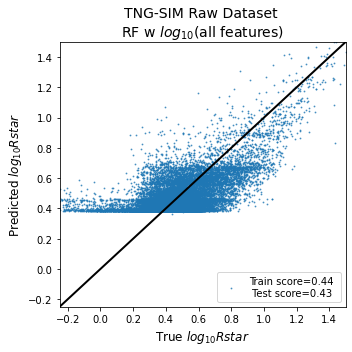

Elapsed time to compute the importances: 0.006 seconds
Elapsed time to compute the importances: 0.410 seconds


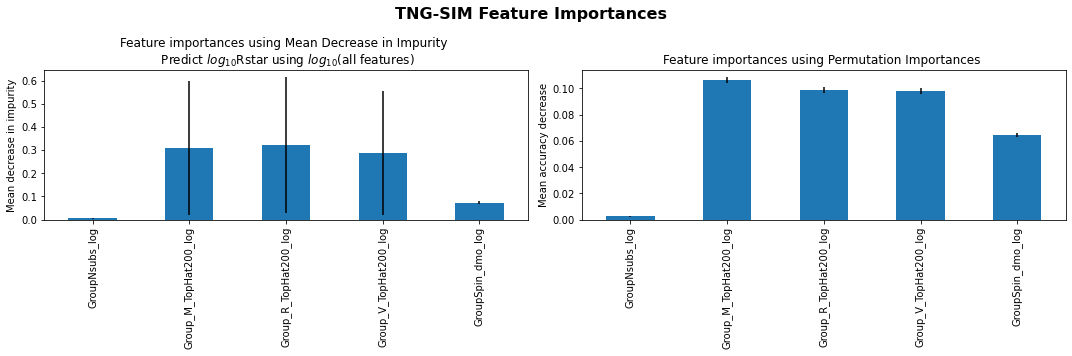

/Users/festabu/miniforge3/envs/native/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


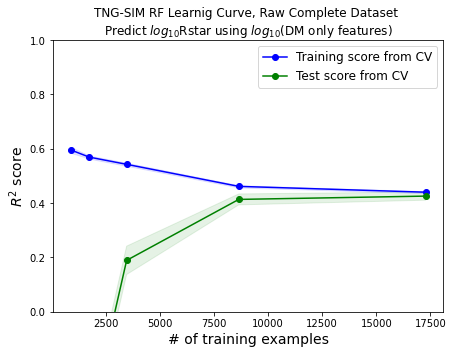

Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset w DM only features: 209.846 seconds


In [17]:
# this code takes 2242.162 seconds ~37min to run when the dataset is TNG100-SIM galaxies
# with ~22,000 entries 
start_time = time.time()

RF_lc_2 = tp_lc_functions.target_predicting_RF_function(X_dm, y_dm, 'TNG-SIM RF Learnig Curve, Raw Complete Dataset \n'+r'Predict $log_{10}$Rstar using $log_{10}$(DM only features)')

elapsed_time = time.time() - start_time

print(f"Elapsed time to run RF func and Learning Curves on TNG-SIM Raw Complete Dataset w DM only features: {elapsed_time:.3f} seconds")

In [18]:
lc_2 = RF_lc_2[4]
# lc_2.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_RF_Learning_Curve_zoom.jpeg', dpi=500)
lc_3 = RF_lc_2[2]
# lc_3.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_PermutationImportances.jpeg', dpi=500)
# RF_lc_2[3].to_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG_Raw_AllDataset_wDMfeatures_PermutationImportances.csv', index=False)


# y_pred_RF_df_all = RF_lc_2[0]
# y_pred_RF_df_all = pd.DataFrame({'y_pred_RF SIM Raw': y_pred_RF_df_all})

# y_pred_RF_df_all.to_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_y_pred_RF_predicted_sizes.csv', index=False)

y_pred_RF_all = pd.read_csv('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_y_pred_RF_predicted_sizes.csv')

In [19]:
y_pred_RF_all

y_pred_RF SIM Raw
0               1.758153
1               1.681070
2               1.578808
3               1.711367
4               1.743876
...                  ...
21593           0.534170
21594           0.560712
21595           0.546925
21596           0.567211
21597           0.534170

[21598 rows x 1 columns]

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('MSE logRstar:', mean_squared_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
print('sqrtMSE logRstar:', np.sqrt(mean_squared_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))
print('MAE logRstar:', mean_absolute_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
print('MAPE logRstar:', mean_absolute_percentage_error(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))
print('r2 score logRstar:', r2_score(df_raw_log.loc[:, 'SubhaloRstar_log'], y_pred_RF_all.loc[:,'y_pred_RF SIM Raw']))

print('Original var MAPE Rstar:', # MAPE in original variables
mean_absolute_percentage_error(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))
print('Origina var r2 score:', r2_score(10**(df_raw_log.loc[:, 'SubhaloRstar_log']), 10**(y_pred_RF_all.loc[:,'y_pred_RF SIM Raw'])))

MSE logRstar: 0.023560891202709388
sqrtMSE logRstar: 0.1534955738863808
MAE logRstar: 0.11438175570068607
MAPE logRstar: 5.106541524538937
r2 score logRstar: 0.42570020565308153
Original var MAPE Rstar: 0.2889826907635649
Origina var r2 score: 0.6638971073944903


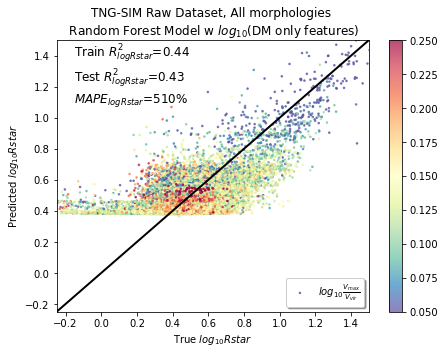

In [22]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_raw_log.SubhaloRstar_log, y_pred_RF_all,
            c = df_0D_log.SubhaloVmax_hs_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}\frac{V_{max}}{V_{vir}}$', vmin=0.05, vmax=0.25)
ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.44' + '\n' + r'Test $R^{2}_{logRstar}$=0.43' + '\n' + r'$MAPE_{logRstar}$=510$\%$ ', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'Random Forest Model w $log_{10}$(DM only features) ')
ax.set_xlabel(r'True $log_{10}Rstar$')
ax.set_ylabel(r'Predicted $log_{10}Rstar$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_RF_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

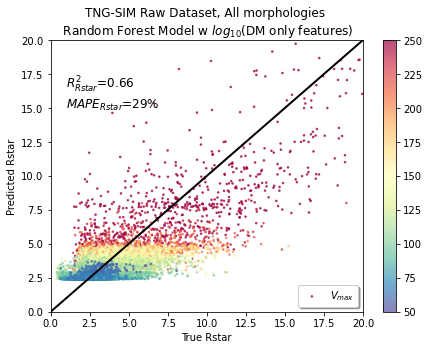

In [24]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_raw_log.SubhaloRstar_log), 10**(y_pred_RF_all),
            c = df_raw.SubhaloVmax, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$V_{max}$', vmin=50, vmax=250)
ax.text(1.0, 15, r'$R^{2}_{Rstar}$=0.66' + '\n' + r'$MAPE_{Rstar}$=29$\%$ ', size=12)
ax.axis([0.0,20, 0.0,20])
ax.plot([0, 30], [0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, All morphologies \n ' + r'Random Forest Model w $log_{10}$(DM only features) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v15_RF_FeatRank_Raw/v15_TNG-SIM_Raw_AllDataset_wDMfeatures_RF_size_pred_colorlogVmaxVvir_2.jpeg', dpi=500)
plt.show()